In [1]:
import pandas as pd

pd.set_option("display.precision", 3)
import os
import warnings

warnings.filterwarnings("ignore")
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from ConsensusClusteringSingleView import ConsensusCluster
import scipy.stats as sps
import copy
from tqdm import tqdm
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN
from tqdm import tqdm

from pathlib import Path
from itertools import product
import matplotlib.cm as cm
import matplotlib.lines as mlines
from ConsensusClusteringSingleView import ConsensusCluster

In [2]:
Cov = "_CovNotStandardized"
data_path = "data{}/".format(Cov)
score_path = "{}/Clustering_silhouette/".format(data_path)
cdf_path = "{}/CDF plots/".format(data_path)
tsne_path = "{}/TSNEplots/".format(data_path)
for path in [score_path, cdf_path, tsne_path]:
    Path(path).mkdir(parents=True, exist_ok=True)
refer_id = pd.read_csv("data/ProteomeViewMICEimputed.csv", index_col=0)

# KMeans CDF plot

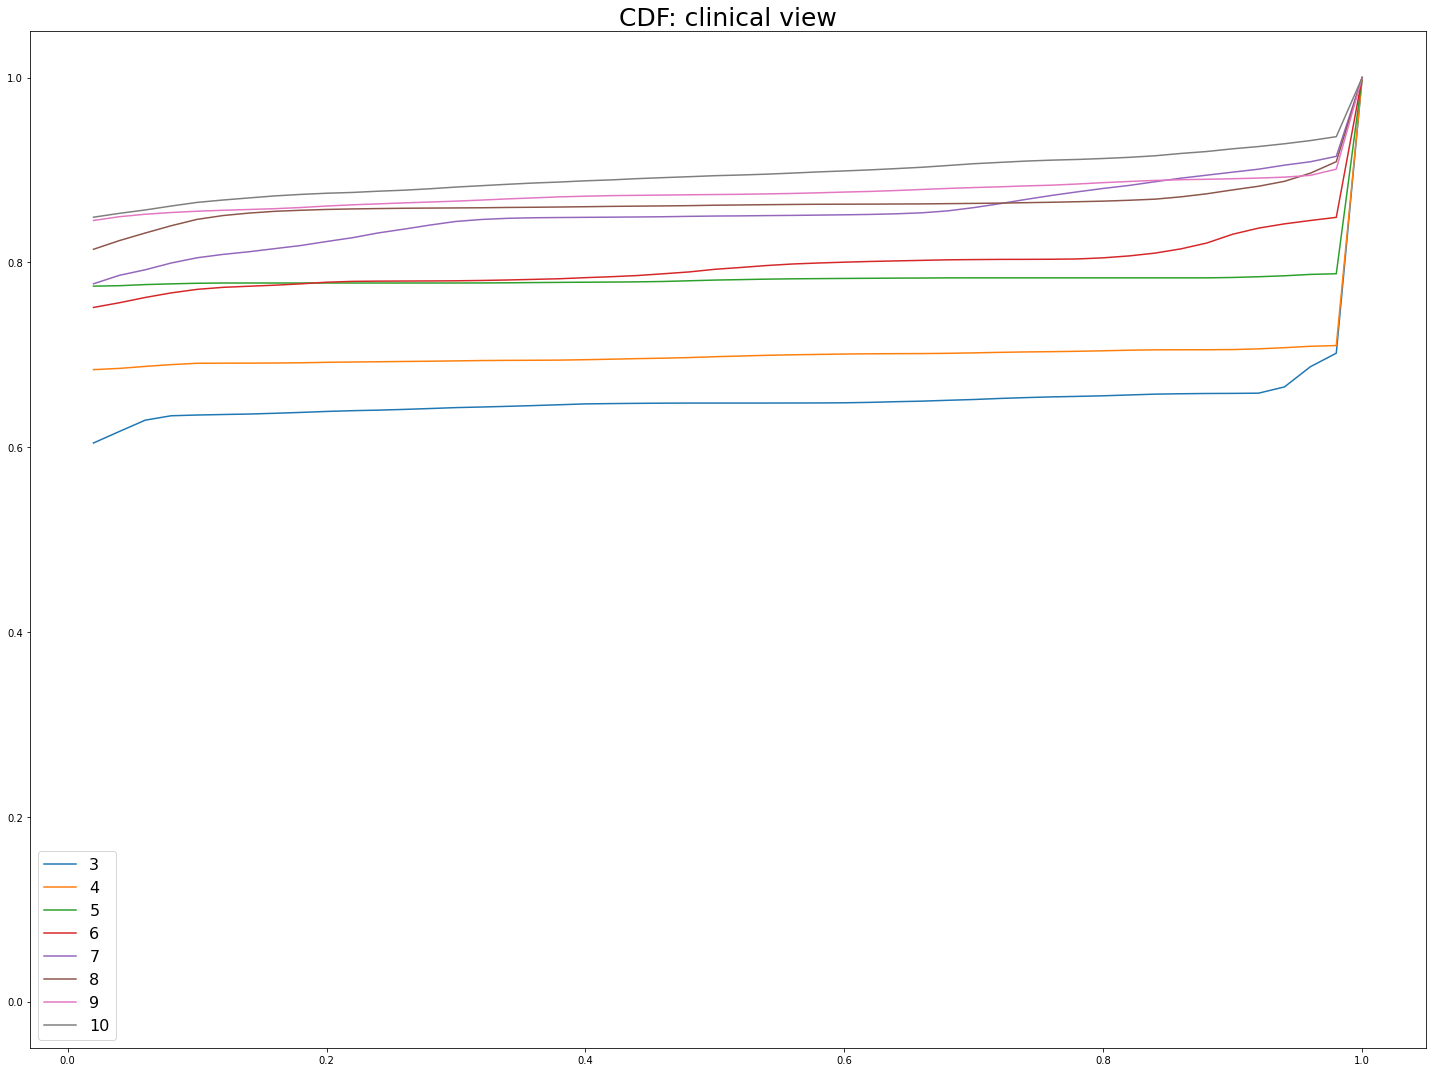

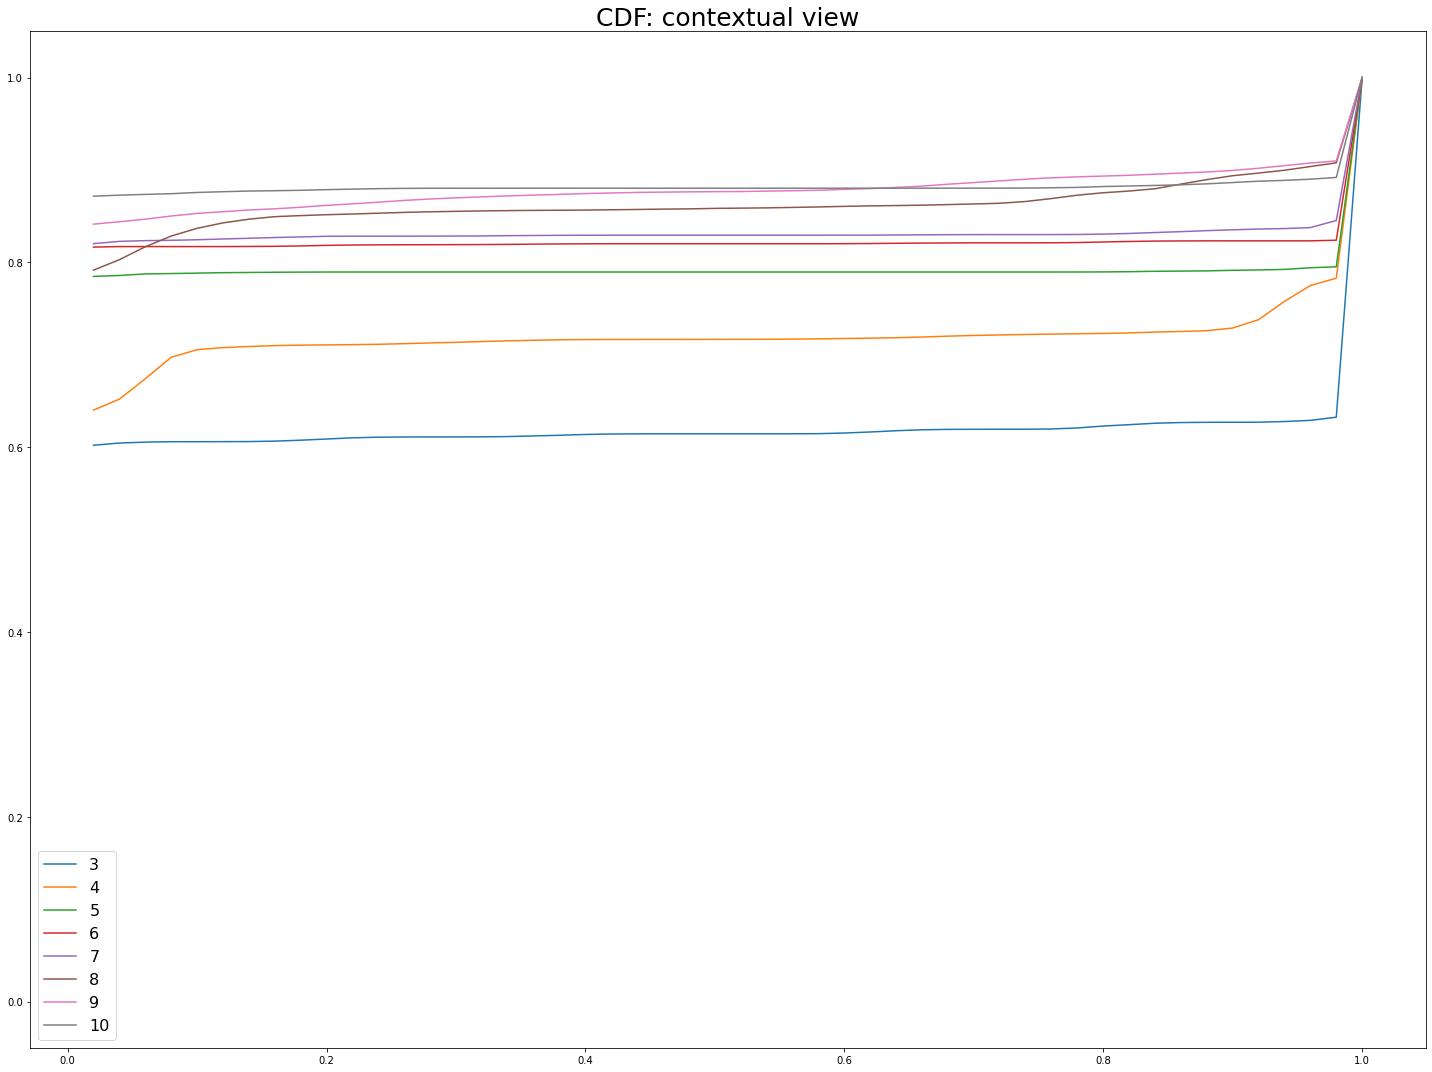

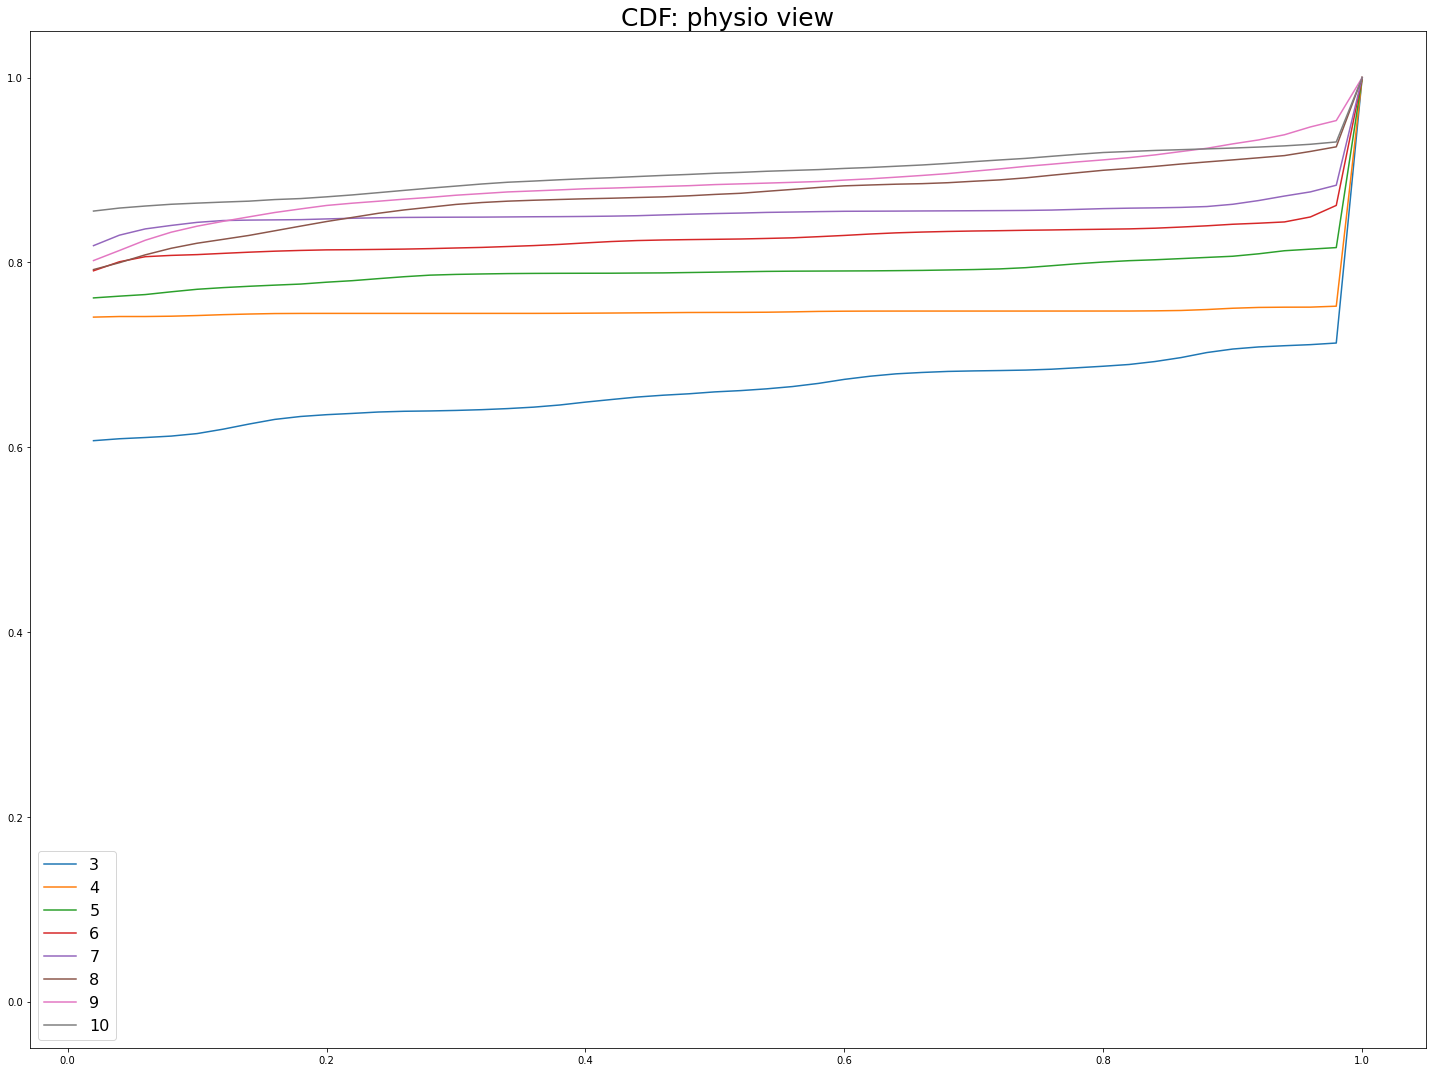

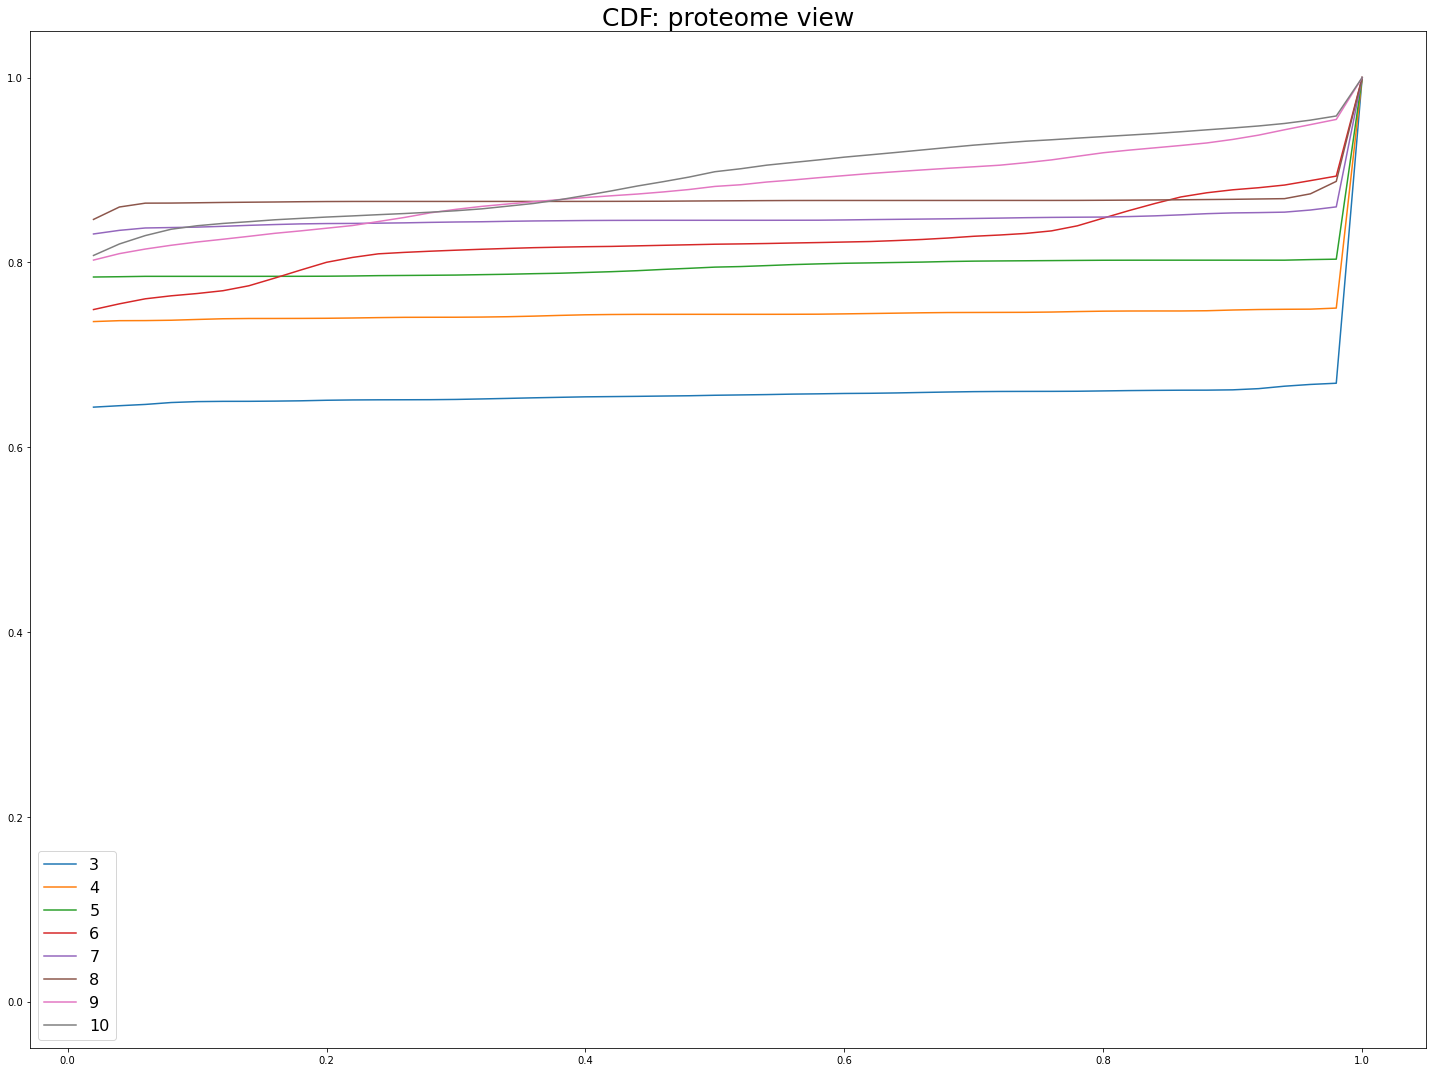

In [7]:
for view in ['clinical', 'contextual', 'physio', 'proteome']:
    report = pd.read_csv('{}/ConsensusKMeans_{}_view.csv'.format(score_path, view), index_col=0)
    Mks = []
    for KCC_space in range(3, 11):
        data = pd.read_csv(
            "{}/KCC_Cov_AgeSexEth_{}_NormalImputation_K{}.csv".format(
                data_path, view, KCC_space
            ),
            header=None,
        )
        assert data.shape == (387, KCC_space)
        report_sub = report[report['KCC_space'] == KCC_space].sort_values('silhouette_score', ascending=False).iloc[0]

        cons = ConsensusCluster(KMeans, KCC_space, KCC_space + 1, 100, resample_proportion=0.8)
        perplexity, random_state = int(report_sub['perplexity']), int(report_sub['random_state'])
        tsne = TSNE(
            perplexity=perplexity, random_state=random_state, n_components=2
        )
        X_emb = tsne.fit_transform(data.values)
        assert X_emb.shape == (387, 2)
        cons.fit(pd.DataFrame(X_emb))
        assignment = cons.predict_data(X_emb) + 1
        Mks.append(cons.Mk[0])

    Aks = []
    plt.figure(figsize=(20, 15))
    for KCC_space in range(3, 11):
        hist, bins = np.histogram(Mks[KCC_space - 3].ravel(), bins=50)
        pdf = hist / sum(hist)
        cdf = np.cumsum(pdf)
        acdf = np.sum(h * (b - a) for b, a, h in zip(bins[1:], bins[:-1], cdf))
        Aks.append(acdf)
        plt.plot(bins[1:], cdf, label=KCC_space)

    plt.legend(fontsize=16)
    plt.title("CDF: {} view".format(view), fontsize=25)

    plt.ylim(-0.05, 1.05)
    plt.tight_layout()
    plt.savefig('{}/ConsensusKMeans_{}_view_CDFplot.png'.format(cdf_path, view), dpi=300)
    plt.show()

# best KMeans case

View                clinical
KCC_space                  4
TSNE                    True
perplexity              50.0
random_state             3.0
silhouette_score        0.56
Name: 95, dtype: object

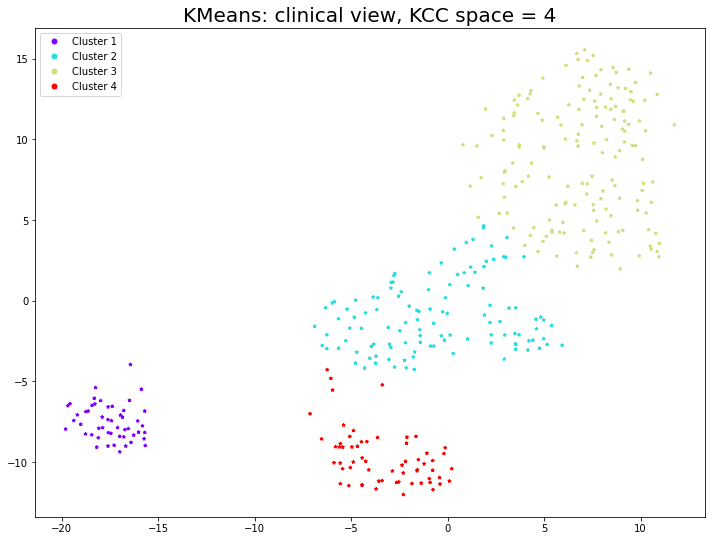

View                contextual
KCC_space                    3
TSNE                      True
perplexity                20.0
random_state               6.0
silhouette_score         0.621
Name: 27, dtype: object

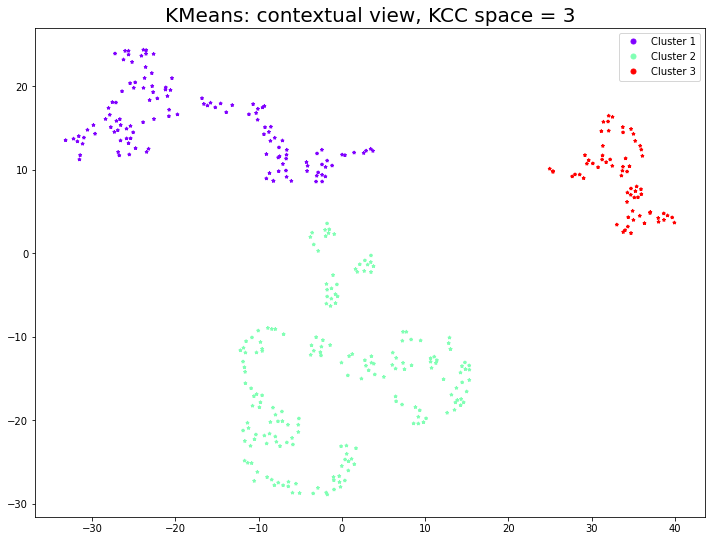

View                physio
KCC_space                4
TSNE                  True
perplexity            20.0
random_state           1.0
silhouette_score     0.529
Name: 73, dtype: object

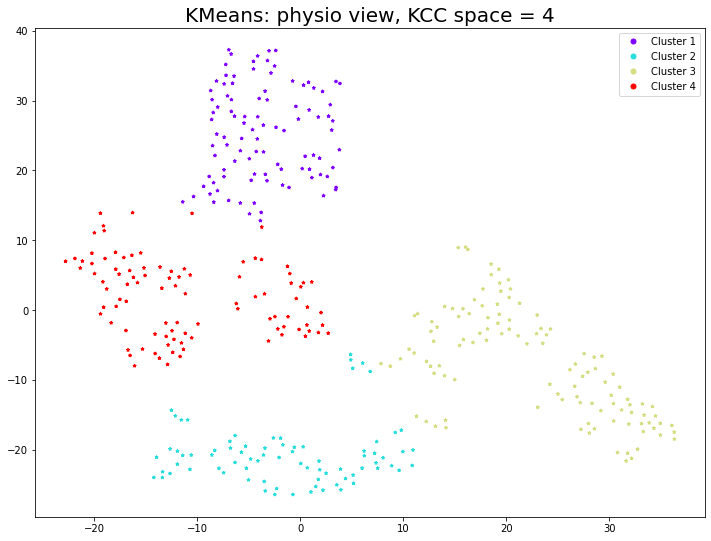

View                proteome
KCC_space                  3
TSNE                    True
perplexity              20.0
random_state             8.0
silhouette_score       0.599
Name: 29, dtype: object

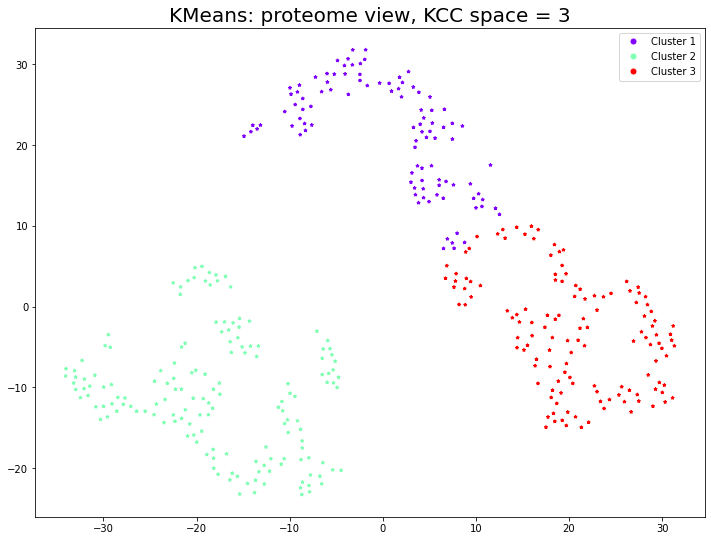

In [9]:
for view in ['clinical', 'contextual', 'physio', 'proteome']:
    report = pd.read_csv('{}/ConsensusKMeans_{}_view.csv'.format(score_path, view), index_col=0)
    report = report.sort_values('silhouette_score', ascending=False).iloc[0]
    KCC_space = report["KCC_space"]

    data = pd.read_csv(
            "{}/KCC_Cov_AgeSexEth_{}_NormalImputation_K{}.csv".format(
                data_path, view, KCC_space
            ),
            header=None,
    )
    display(report)

    cons = ConsensusCluster(KMeans, KCC_space, KCC_space + 1, 100, resample_proportion=0.8)
    perplexity, random_state = int(report['perplexity']), int(report['random_state'])
    tsne = TSNE(
        perplexity=perplexity, random_state=random_state, n_components=2
    )
    X_emb = tsne.fit_transform(data.values)
    assert X_emb.shape == (387, 2)
    cons.fit(pd.DataFrame(X_emb))
    assignment = cons.predict_data(X_emb) + 1

    plt.figure(figsize=(12, 9))
    legends = []
    cmap = cm.rainbow(np.linspace(0, 1, KCC_space))
    colors = np.array([cmap[i - 1] for i in assignment])
    for i in range(KCC_space):
        legends.append(
            mlines.Line2D(
                [],
                [],
                color=cmap[i],
                marker=".",
                linestyle="None",
                markersize=10,
                label="Cluster {}".format(i + 1),
            )
        )
    plt.scatter(
        X_emb[:, 0],
        X_emb[:, 1],
        color=colors,
        s=10,
        marker="*",
    )
    plt.title(
        "KMeans: {} view, KCC space = {}".format(
            view, KCC_space
        ),
        fontsize=20,
    )
    plt.legend(handles=legends, fontsize=10)
    plt.savefig('{}/ConsensusKMeans_{}_view_KCC_{}.png'.format(tsne_path, view, KCC_space), dpi=300)
    plt.show()

    X_emb = pd.DataFrame(X_emb, index=refer_id.index, columns=['TSNE 1', 'TSNE_2'])
    X_emb.to_csv('{}/ConsensusKMeans_{}_view_KCC_{}_TSNE_embeddings.csv'.format(score_path, view, KCC_space))

    assignment = pd.DataFrame(assignment, index=refer_id.index, columns=['assignment'])
    assignment.to_csv('{}/ConsensusKMeans_{}_view_KCC_{}_assignments.csv'.format(score_path, view, KCC_space))

View                proteome
KCC_space                  4
TSNE                    True
perplexity              50.0
random_state             6.0
silhouette_score       0.529
Name: 98, dtype: object

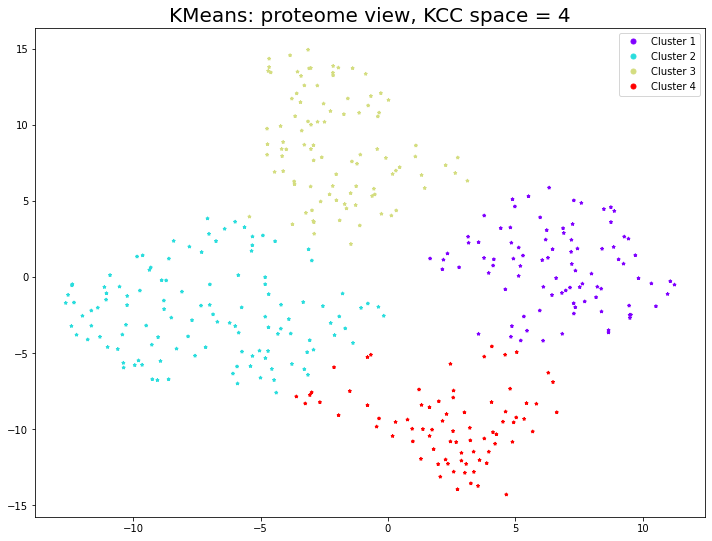

In [18]:
for view in ['proteome']:
    report_sup = pd.read_csv('{}/ConsensusKMeans_{}_view.csv'.format(score_path, view), index_col=0)
    KCC_spaces = [4]
    for KCC_space in KCC_spaces:

        report = report_sup[report_sup["KCC_space"] == KCC_space]
        report = report.sort_values('silhouette_score', ascending=False).iloc[0]
        KCC_space = report["KCC_space"]

        data = pd.read_csv(
                "{}/KCC_Cov_AgeSexEth_{}_NormalImputation_K{}.csv".format(
                    data_path, view, KCC_space
                ),
                header=None,
        )
        display(report)

        cons = ConsensusCluster(KMeans, KCC_space, KCC_space + 1, 100, resample_proportion=0.8)
        perplexity, random_state = int(report['perplexity']), int(report['random_state'])
        tsne = TSNE(
            perplexity=perplexity, random_state=random_state, n_components=2
        )
        X_emb = tsne.fit_transform(data.values)
        assert X_emb.shape == (387, 2)
        cons.fit(pd.DataFrame(X_emb))
        assignment = cons.predict_data(X_emb) + 1

        plt.figure(figsize=(12, 9))
        legends = []
        cmap = cm.rainbow(np.linspace(0, 1, KCC_space))
        colors = np.array([cmap[i - 1] for i in assignment])
        for i in range(KCC_space):
            legends.append(
                mlines.Line2D(
                    [],
                    [],
                    color=cmap[i],
                    marker=".",
                    linestyle="None",
                    markersize=10,
                    label="Cluster {}".format(i + 1),
                )
            )
        plt.scatter(
            X_emb[:, 0],
            X_emb[:, 1],
            color=colors,
            s=10,
            marker="*",
        )
        plt.title(
            "KMeans: {} view, KCC space = {}".format(
                view, KCC_space
            ),
            fontsize=20,
        )
        plt.legend(handles=legends, fontsize=10)
        plt.savefig('{}/ConsensusKMeans_{}_view_KCC_{}.png'.format(tsne_path, view, KCC_space), dpi=300)
        plt.show()

        X_emb = pd.DataFrame(X_emb, index=refer_id.index, columns=['TSNE 1', 'TSNE_2'])
        X_emb.to_csv('{}/ConsensusKMeans_{}_view_KCC_{}_TSNE_embeddings.csv'.format(score_path, view, KCC_space))

        assignment = pd.DataFrame(assignment, index=refer_id.index, columns=['assignment'])
        assignment.to_csv('{}/ConsensusKMeans_{}_view_KCC_{}_assignments.csv'.format(score_path, view, KCC_space))

In [17]:
X_emb_3 = X_emb
assignment_3 = assignment

In [19]:
X_emb_4 = X_emb
assignment_4 = assignment

In [30]:
index_0 = assignment_3[assignment_3['assignment'] == 1].index

In [31]:
index_1 = assignment_4[(assignment_4['assignment'] == 1) | (assignment_4['assignment'] == 4)].index

In [32]:
index_0.isin(index_1).sum()

154

In [23]:
assignment_3_4 = pd.concat([assignment_3, assignment_4], 1)
assignment_3_4.columns= [3, 4]

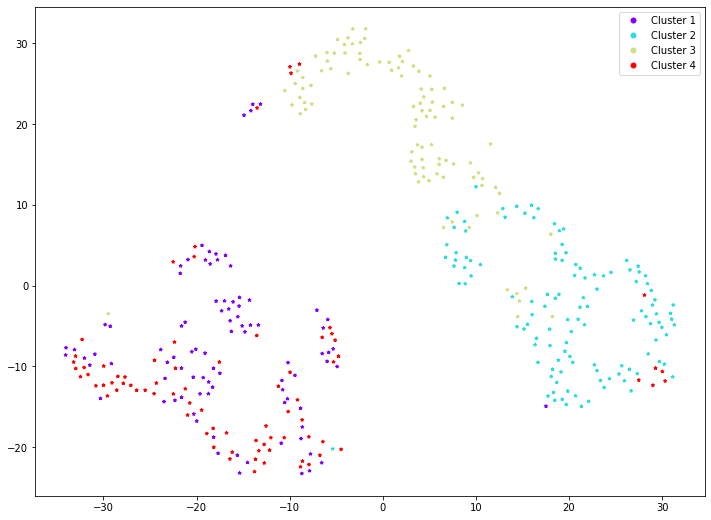

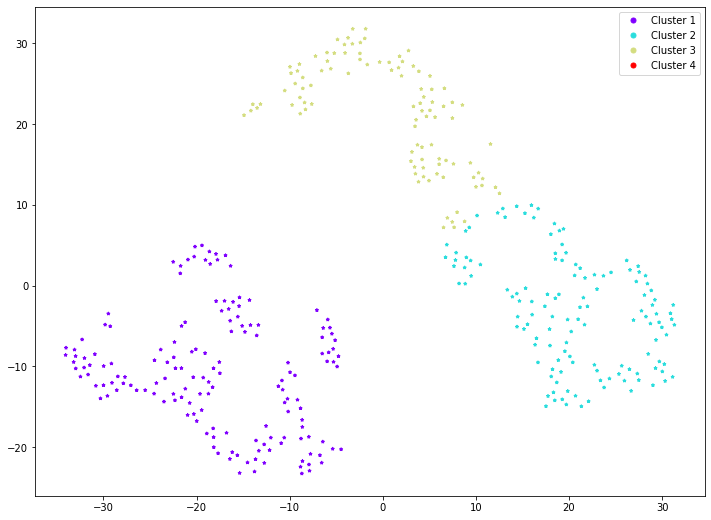

In [40]:
plt.figure(figsize=(12, 9))
legends = []
cmap = cm.rainbow(np.linspace(0, 1, len(assignment_4['assignment'].unique())))
colors = np.array([cmap[i - 1] for i in assignment_4['assignment']])
for i in range(KCC_space):
    legends.append(
        mlines.Line2D(
            [],
            [],
            color=cmap[i],
            marker=".",
            linestyle="None",
            markersize=10,
            label="Cluster {}".format(i + 1),
        )
    )
plt.scatter(
    X_emb_3.values[:, 0],
    X_emb_3.values[:, 1],
    color=colors,
    s=10,
    marker="*",
)

plt.legend(handles=legends, fontsize=10)
plt.show()

plt.figure(figsize=(12, 9))
legends = []
cmap = cm.rainbow(np.linspace(0, 1, len(assignment_4['assignment'].unique())))
colors = np.array([cmap[i - 1] for i in assignment_3['assignment']])
for i in range(KCC_space):
    legends.append(
        mlines.Line2D(
            [],
            [],
            color=cmap[i],
            marker=".",
            linestyle="None",
            markersize=10,
            label="Cluster {}".format(i + 1),
        )
    )
plt.scatter(
    X_emb_3.values[:, 0],
    X_emb_3.values[:, 1],
    color=colors,
    s=10,
    marker="*",
)

plt.legend(handles=legends, fontsize=10)
plt.show()

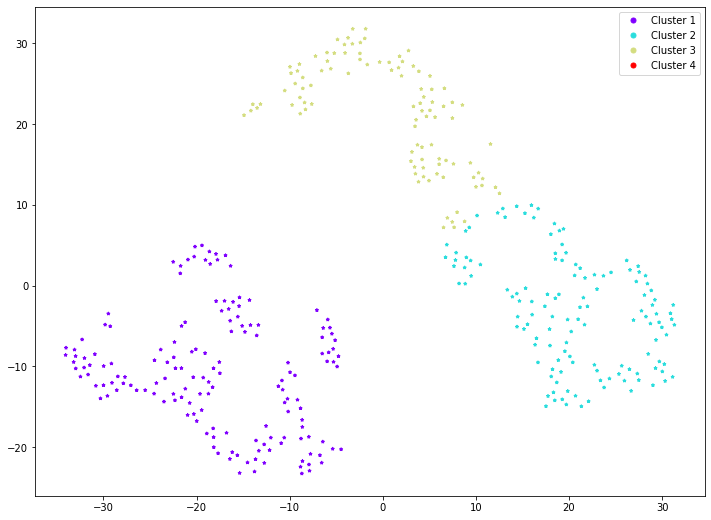

In [39]:
plt.figure(figsize=(12, 9))
legends = []
cmap = cm.rainbow(np.linspace(0, 1, len(assignment_4['assignment'].unique())))
colors = np.array([cmap[i - 1] for i in assignment_3['assignment']])
for i in range(KCC_space):
    legends.append(
        mlines.Line2D(
            [],
            [],
            color=cmap[i],
            marker=".",
            linestyle="None",
            markersize=10,
            label="Cluster {}".format(i + 1),
        )
    )
plt.scatter(
    X_emb_3.values[:, 0],
    X_emb_3.values[:, 1],
    color=colors,
    s=10,
    marker="*",
)

plt.legend(handles=legends, fontsize=10)
plt.show()

# best DBSCAN case

View                clinical
KCC_space                  3
TSNE                    True
perplexity                30
random_state               0
eps                    2.524
min_samples                7
n_state                    0
silhouette_score       0.649
DBSCAN_clusters            2
outlier_ratio          0.008
Name: 551, dtype: object


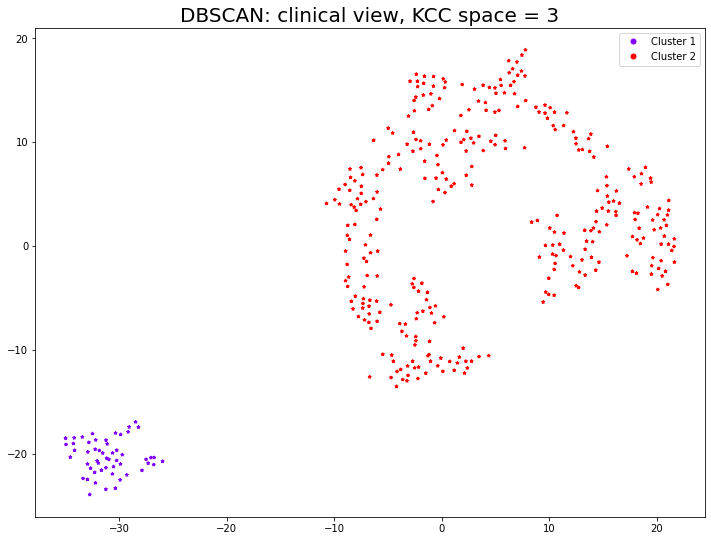

View                contextual
KCC_space                    6
TSNE                      True
perplexity                  30
random_state                 3
eps                      2.727
min_samples                 16
n_state                      0
silhouette_score         0.624
DBSCAN_clusters              8
outlier_ratio            0.049
Name: 9801, dtype: object


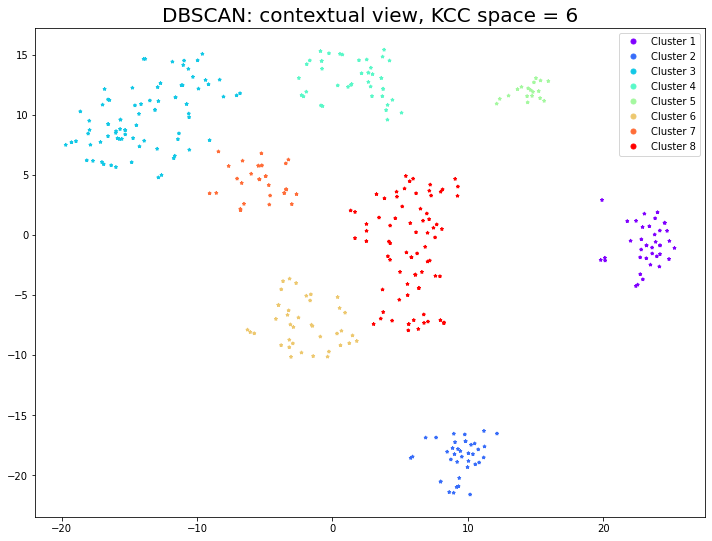

View                physio
KCC_space                3
TSNE                  True
perplexity              30
random_state             3
eps                  2.929
min_samples             12
n_state                  0
silhouette_score     0.558
DBSCAN_clusters          4
outlier_ratio        0.049
Name: 733, dtype: object


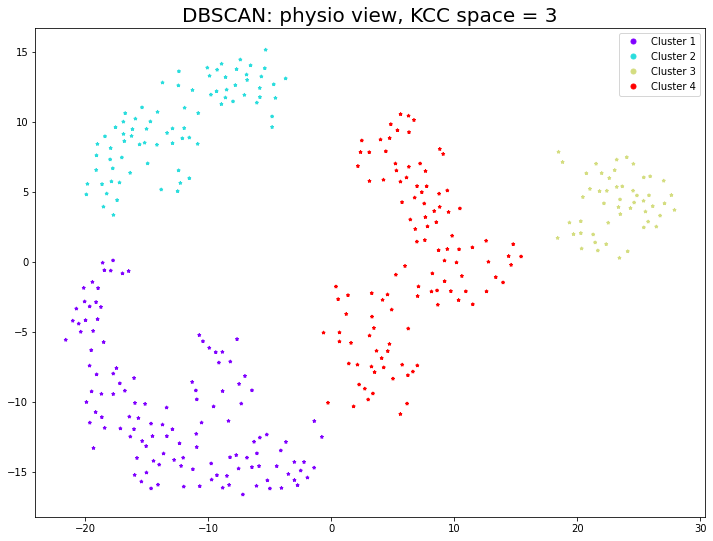

View                proteome
KCC_space                  3
TSNE                    True
perplexity                30
random_state               1
eps                    2.727
min_samples                7
n_state                    0
silhouette_score       0.635
DBSCAN_clusters            2
outlier_ratio           0.01
Name: 535, dtype: object


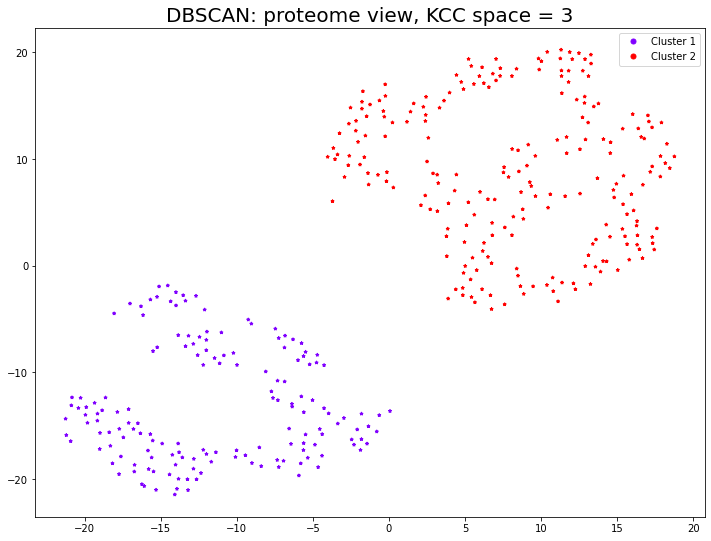

In [13]:
for view in ['clinical', 'contextual', 'physio', 'proteome']:
    KCC_spaces = [3]
    report = pd.read_csv(
        "{}/DBSCAN_{}_view.csv".format(score_path, view), index_col=0
    )
    
    #report = report_sup[report_sup["KCC_space"] == KCC_space]
    report = report[report["outlier_ratio"] <= 0.05]
    report = report.sort_values("silhouette_score", ascending=False).iloc[0]
    KCC_space = report['KCC_space']
    print(report)

    data = pd.read_csv(
        "{}/KCC_Cov_AgeSexEth_{}_NormalImputation_K{}.csv".format(
            data_path, view, KCC_space
        ),
        header=None,
    )

    perplexity, random_state = int(report["perplexity"]), int(
        report["random_state"]
    )
    eps, min_samples = report["eps"], report["min_samples"]
    tsne = TSNE(perplexity=perplexity, random_state=random_state, n_components=2)
    X_emb = tsne.fit_transform(data.values)
    cluster = DBSCAN(eps=eps, min_samples=min_samples)
    cluster.fit(X_emb)
    score = silhouette_score(
        X_emb[cluster.labels_ != -1],
        cluster.labels_[cluster.labels_ != -1],
    )
    TSNE_emb = pd.DataFrame(
        X_emb, index=refer_id.index, columns=["TSNE 1", "TSNE_2"]
    )
    assignment = pd.DataFrame(
        cluster.labels_, index=refer_id.index, columns=["assignment"]
    )

    TSNE_emb.to_csv(
        "{}/DBSCAN_{}_view_KCC_{}_TSNE_embeddings.csv".format(
            score_path, view, KCC_space
        )
    )

    assignment.to_csv(
        "{}/DBSCAN_{}_view_KCC_{}_assignments.csv".format(
            score_path, view, KCC_space
        )
    )
    
    assignment = cluster.labels_
    
    X_emb_csv = pd.DataFrame(X_emb, index=refer_id.index, columns=['TSNE 1', 'TSNE_2'])
    X_emb_csv.to_csv('{}/DBSCAN_{}_view_KCC_{}_TSNE_embeddings.csv'.format(score_path, view, KCC_space))

    assignment_csv = pd.DataFrame(assignment, index=refer_id.index, columns=['assignment'])
    assignment_csv.to_csv('{}/DBSCAN_{}_view_KCC_{}_assignments.csv'.format(score_path, view, KCC_space))

    X_emb = X_emb[cluster.labels_ != -1]
    assignment = cluster.labels_[cluster.labels_ != -1]

    plt.figure(figsize=(12, 9))
    legends = []
    cmap = cm.rainbow(np.linspace(0, 1, len(np.unique(assignment))))
    colors = np.array([cmap[i - 1] for i in assignment])
    for i in range(len(np.unique(assignment))):
        legends.append(
            mlines.Line2D(
                [],
                [],
                color=cmap[i],
                marker=".",
                linestyle="None",
                markersize=10,
                label="Cluster {}".format(i + 1),
            )
        )
        
    plt.scatter(
        X_emb[:, 0],
        X_emb[:, 1],
        color=colors,
        s=10,
        marker="*",
    )
    plt.title(
        "DBSCAN: {} view, KCC space = {}".format(view, KCC_space),
        fontsize=20,
    )
    plt.legend(handles=legends, fontsize=10)
    plt.savefig(
        "{}/DBSCAN_{}_view_KCC_{}.png".format(tsne_path, view, KCC_space), dpi=300
    )
    plt.show()